<a href="https://colab.research.google.com/github/AngeloBongiorno/AML_2025_project4/blob/angelo/STEP_2A_deeplab_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Dependency & DeepLab

## Upload .zip files

For this step you must have the zip files in your Drive into a folder called `AML_project`

In [ ]:
!pip install torchmetrics
!pip install fvcore

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 60.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninst

In [ ]:
from google.colab import drive
import os

!git clone -b vito --single-branch https://github.com/AngeloBongiorno/AML_2025_project4.git

!cp AML_2025_project4/utils.py .

drive.mount('/content/drive')

Cloning into 'AML_2025_project4'...
remote: Enumerating objects: 211, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 211 (delta 56), reused 40 (delta 40), pack-reused 139 (from 2)
Receiving objects: 100% (211/211), 94.53 MiB | 12.52 MiB/s, done.
Resolving deltas: 100% (80/80), done.
Mounted at /content/drive


In [ ]:
import tqdm
import zipfile
import os

# ZIP files paths on Google Drive
zip_files = {
    "training": "/content/drive/My Drive/AML_project/Train.zip",
    "validation": "/content/drive/My Drive/AML_project/Val.zip",
}

# Destination directory on Colab
extract_path = "/content/dataset"

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)


for name, zip_path in zip_files.items():
    extract_dir = f"{extract_path}/{name}"

    # Check if the directory is non-empty (assumes extraction is complete if the folder has files)
    if os.path.exists(extract_dir) and any(os.scandir(extract_dir)):
        print(f"Skipping extraction for {name}, already extracted.")
    else:
        print(f"Extracting {name}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"{name} extracted!")

print("Extraction check completed!")

TRAINING_PATH_URBAN = os.path.join(extract_path, "training", "Train", "Urban")
TRAINING_PATH_RURAL = os.path.join(extract_path, "training", "Train", "Rural")
VAL_PATH_URBAN = os.path.join(extract_path, "validation", "Val", "Urban")
VAL_PATH_RURAL = os.path.join(extract_path, "validation", "Val", "Rural")

Extracting training...
training extracted!
Extracting validation...
validation extracted!
Extraction check completed!


## Load DeepLab v2 PreTrained Weight

Crea la cartella model e inserisce il modello DeepLabv2


In [ ]:
import requests
from pathlib import Path

models_dir = Path("models")
deeplab_file = models_dir / "DeepLab_v2.py"

models_dir.mkdir(parents=True, exist_ok=True)

if deeplab_file.is_file():
    print("DeepLab-v2.py already exists in 'models/' folder, skipping download.")
else:
    print("Downloading DeepLab-v2.py to 'models/' folder.")

    url = "https://raw.githubusercontent.com/Gabrysse/MLDL2024_project1/refs/heads/master/models/deeplabv2/deeplabv2.py"
    response = requests.get(url)

    if response.status_code == 200:
        with open(deeplab_file, "wb") as f:
            f.write(response.content)
        print("Download completed successfully!")
    else:
        print(f"Failed to download file. HTTP Status Code: {response.status_code}")


Download completed successfully!


In [ ]:
import sys
from pathlib import Path

models_dir = Path("models")
sys.path.append(str(models_dir))

from DeepLab_v2 import get_deeplab_v2


Implementazione del dataloader

In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import numpy as np

RESIZE = (512, 512)

SEM_CLASSES = [
    'background',
    'building',
    'road',
    'water',
    'barren',
    'forest',
    'agriculture'
]

NUM_CLASSES = len(SEM_CLASSES)

sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(SEM_CLASSES)}

val_ratio = 0.2


class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_filenames = sorted(os.listdir(image_dir))
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
          mask = self.target_transform(mask)

        mask = torch.as_tensor(np.array(mask), dtype=torch.int64) - 1

        return image, mask  # Return (image, mask) pair

# Define transformations for images & masks
image_transform = transforms.Compose([
    transforms.Resize(RESIZE, interpolation=Image.BILINEAR),  # Resize images to 256x256
    transforms.ToTensor(),  # Convert image to tensor
])

mask_transform = transforms.Compose([
    transforms.Resize(RESIZE, interpolation=Image.NEAREST),  # Resize masks to 256x256
])

# Create dataset objects
train_and_val_dataset_urban = SegmentationDataset(TRAINING_PATH_URBAN + "/images_png", TRAINING_PATH_URBAN + "/masks_png",
                                    transform=image_transform, target_transform=mask_transform)

generator = torch.Generator().manual_seed(42)
val_size = int(len(train_and_val_dataset_urban) * val_ratio)
train_size = len(train_and_val_dataset_urban) - val_size

# Random split
train_dataset_urban, val_dataset_urban = random_split(train_and_val_dataset_urban, [train_size, val_size], generator=generator)


test_dataset_urban = SegmentationDataset(VAL_PATH_URBAN + "/images_png", VAL_PATH_URBAN + "/masks_png",
                                  transform=image_transform, target_transform= mask_transform)

print(f"Training set size: {len(train_dataset_urban)}")
print(f"Validation set size: {len(val_dataset_urban)}")
print(f"Test set size: {len(test_dataset_urban)}")

BATCH_SIZE = 8

# Create DataLoaders
train_loader = DataLoader(train_dataset_urban, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset_urban, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset_urban, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

Training set size: 925
Validation set size: 231
Test set size: 677


In [ ]:
from pathlib import Path
import sys

print(os.getcwd())


sys.path.append(str(Path('/content/deeplab-pytorch/deeplab-pytorch/MLDL2024_project1/test')))

# Path of the model
model_path = Path("/content/drive/MyDrive/AML_project/deeplab_resnet_pretrained_imagenet.pth")

# Loading the model using DeepLab v2
model = get_deeplab_v2(num_classes=NUM_CLASSES, pretrain=True, pretrain_model_path=model_path)

/content
Deeplab pretraining loading...


## Training Phase

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device);

cuda


In [ ]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index= -1)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
from tqdm import tqdm
import torch
from torchmetrics.segmentation import MeanIoU

from utils import train_step, validation_step

os.makedirs("/content/drive/MyDrive/AML_project/checkpoints", exist_ok=True)

EPOCHS = 20
torch.manual_seed(42)

miou_classes = MeanIoU(num_classes=NUM_CLASSES, input_format = "index", per_class=True).to(device)


record_miou = None

for epoch in range(EPOCHS):

  avg_train_loss = train_step(model=model,
               optimizer=optimizer,
               loss_fn=loss_fn,
               train_loader=train_loader,
               device=device,
               epoch=epoch,
               EPOCHS=EPOCHS
               )

  # Valutazione del modello

  avg_val_loss, miou_score = validation_step(model=model,
                                             val_loader=val_loader,
                                             loss_fn=loss_fn,
                                             device=device,
                                             miou=miou_classes)

  print(f"Epoch {epoch+1}/{EPOCHS} | Training Loss: {avg_train_loss} | Validation Loss: {avg_val_loss} | mIoU: {miou_score:.4f}")



  if record_miou is None or miou_score > record_miou:
    best_model_path = f"/content/drive/MyDrive/AML_project/checkpoints/best_deeplabv2_2a_model_split.pth"
    torch.save(model.state_dict(), best_model_path)
    print(f"Modello salvato: {best_model_path}")

    record_miou = miou_score




Epoch 1/20 | Training Loss: 1.6720929803519413 | Validation Loss: 1.4104917707114384 | mIoU: 0.2826
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/best_deeplabv2_2a_model_split.pth
Epoch 2/20 | Training Loss: 0.9918646149594208 | Validation Loss: 0.9818159937858582 | mIoU: 0.3453
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/best_deeplabv2_2a_model_split.pth
Epoch 3/20 | Training Loss: 0.8881318045073542 | Validation Loss: 0.8867662651785488 | mIoU: 0.3952
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/best_deeplabv2_2a_model_split.pth
Epoch 4/20 | Training Loss: 0.8334618683519035 | Validation Loss: 0.8998712630107485 | mIoU: 0.4197
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/best_deeplabv2_2a_model_split.pth
Epoch 5/20 | Training Loss: 0.7789435468871018 | Validation Loss: 0.8017009476135517 | mIoU: 0.4490
Modello salvato: /content/drive/MyDrive/AML_project/checkpoints/best_deeplabv2_2a_model_split.pth
Epoch 6/20

In [ ]:
import importlib
import utils  # Replace with the actual module name

importlib.reload(utils)

<module 'utils' from '/content/utils.py'>

In [ ]:
best_model_path

'/content/drive/MyDrive/AML_project/checkpoints/best_deeplabv2_2a_model_split.pth'

# Evaluation

## Load best deeplabv2 model for evaluation

In [ ]:
model = get_deeplab_v2(num_classes=NUM_CLASSES, pretrain=False)

try:
  model.load_state_dict(torch.load(best_model_path))
except:
  print(list(torch.load(best_model_path).keys())[:5])

model.to(device)

ResNetMulti(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

## Evaluate

In [ ]:
avg_val_loss, miou_score = validation_step(model=model,
                                          val_loader=test_loader,
                                          loss_fn=loss_fn,
                                          device=device,
                                          miou=miou_classes)

print(f"Test Loss: {avg_val_loss} | mIoU: {miou_score:.4f}")

Test Loss: 1.7060880394542919 | mIoU: 0.3761


*********


FLOPs: 185.015 GFLOPs
Average inference latency is 0.125 seconds.


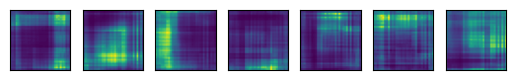

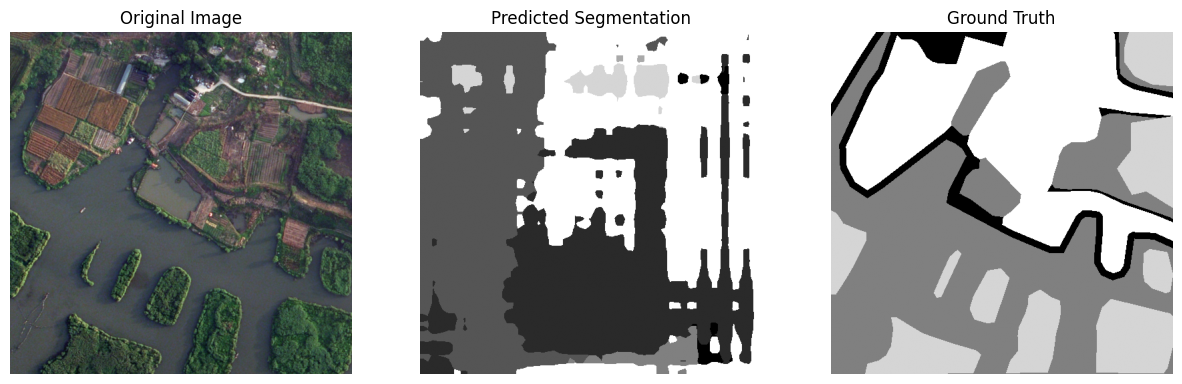

Params: 43.016 M


In [ ]:
from timeit import default_timer as timer
import matplotlib.pyplot as plt
from fvcore.nn import FlopCountAnalysis, flop_count_table
import random

from utils import show

model.eval()  # Set model to evaluation mode



with torch.inference_mode():
    random_index = random.randint(0, len(test_dataset_urban) - 1)
    X, y = test_dataset_urban[random_index]
    X = X.to(device).unsqueeze(dim=0)  # Aggiunge la dimensione batch
    y = y.to(device)

    output = model(X)


flops = FlopCountAnalysis(model, X.clone())


normalized_masks = torch.nn.functional.softmax(output, dim=1)


masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(1)
    for cls in SEM_CLASSES
]

show(masks)


# get the avg latency
with torch.inference_mode():
    img = torch.rand(3, RESIZE[0], RESIZE[1])
    iters = 1000
    latency = []
    for i in range(iters):
        if device.type == 'cuda':
            torch.cuda.synchronize()
        start = timer()
        output = model(img.to(device).unsqueeze(dim=0))
        if device.type == 'cuda':
            torch.cuda.synchronize()
        end = timer()
        latency.append(end - start)
    mean_latency = sum(latency) / len(latency)


#random_index = random.randint(0, len(test_dataset_urban) - 1)
#X, y = test_dataset_urban[random_index]
#X = X.to(device).unsqueeze(dim=0)




print("*********")


print(f"FLOPs: {flops.total() / 1e9:.3f} GFLOPs")
print(f"Average inference latency is {mean_latency:.3f} seconds.")

# Converti output e ground truth per la visualizzazione
out = output.squeeze().argmax(dim=0).cpu().numpy()  # Output segmentazione
y_np = y.squeeze().cpu().numpy()  # Ground truth
X_np = X.squeeze().cpu().permute(1, 2, 0).numpy()  # Immagine originale

# Creazione della figura con tre immagini affiancate
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Immagine originale
axes[0].imshow(X_np)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Predizione del modello
axes[1].imshow(out, cmap="gray")
axes[1].set_title("Predicted Segmentation")
axes[1].axis("off")

# Ground truth
axes[2].imshow(y_np, cmap="gray")
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.show()

# Conta i parametri del modello
params = sum(p.numel() for p in model.parameters())
print(f"Params: {params / 1e6:.3f} M")
